In [32]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf

In [3]:
start_date = datetime.date(2011, 12, 25)
end_date = datetime.date(2023, 6, 21)
df = yf.download('NFLX', start = start_date, end = end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-12-27,10.328571,10.355714,10.028571,10.085714,10.085714,21940800
2011-12-28,10.074286,10.142857,9.795714,9.885714,9.885714,23597000
2011-12-29,9.854286,9.984286,9.658571,9.900000,9.900000,26163200
2011-12-30,9.872857,10.084286,9.832857,9.898571,9.898571,21809200
2012-01-03,10.040000,10.388571,10.018571,10.320000,10.320000,29213800


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-13,430.010010,437.269989,428.399994,435.730011,435.730011,7820500
2023-06-14,434.989990,447.329987,433.500000,440.859985,440.859985,8413100
2023-06-15,444.100006,448.649994,439.500000,445.269989,445.269989,7099900
2023-06-16,446.149994,447.510010,430.899994,431.959991,431.959991,8745500
2023-06-20,430.179993,440.000000,430.000000,434.700012,434.700012,4756000


In [5]:
df = df[['Adj Close']]
df.columns

Index(['Adj Close'], dtype='object')

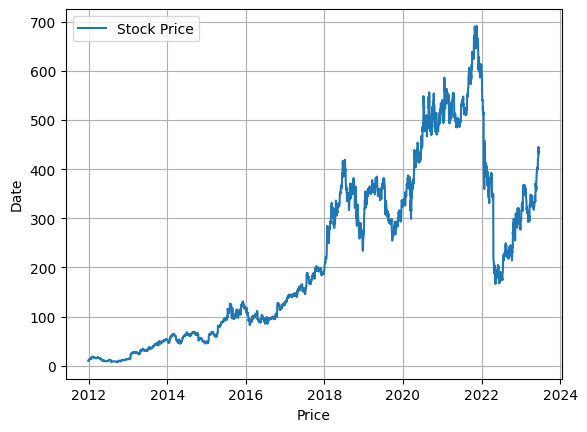

In [6]:
plt.plot(df['Adj Close'], label = 'Stock Price')
plt.xlabel("Price")
plt.ylabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
adf = adfuller(df['Adj Close'])
print("P-value: ",adf[1])
if adf[1] > 0.05:
    print("Netflix time series is non-stationary")
else:
    print("Netflix time series is stationary")

P-value:  0.6977991678573147
Netflix time series is non-stationary


In [8]:
adf = adfuller(df['Adj Close'].diff().dropna())
print("P-value: ",adf[1])
if adf[1] > 0.05:
    print("First differential of Netflix time series is non-stationary")
else:
    print("First differential of Netflix time series is stationary")

P-value:  4.731475266090393e-21
First differential of Netflix time series is stationary


In [9]:
df['Adj Close diff'] = df['Adj Close'].diff()
df.dropna(inplace = True)

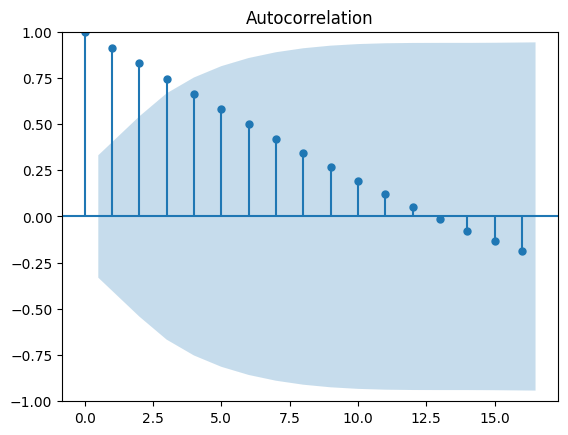

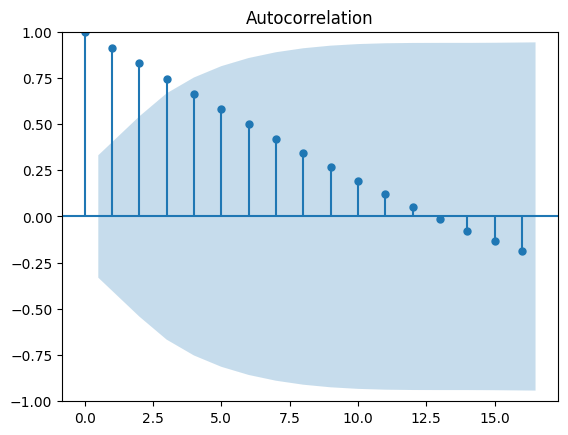

In [10]:
sm.graphics.tsa.plot_acf(sm.tsa.acf(df['Adj Close']))

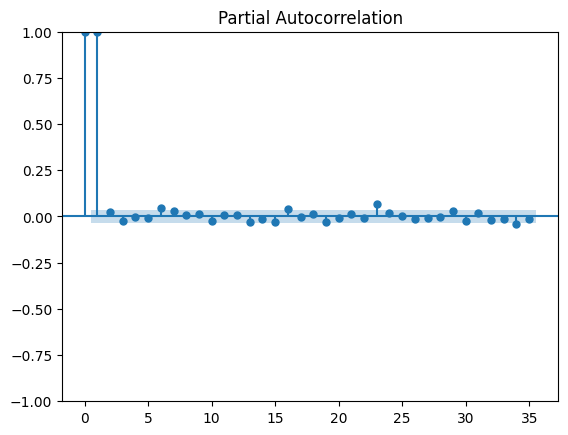

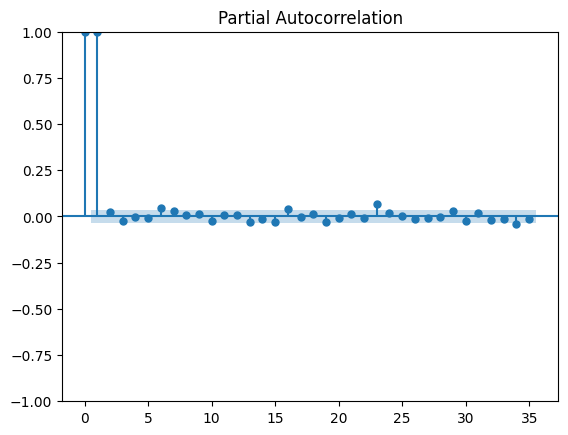

In [11]:
sm.graphics.tsa.plot_pacf(df['Adj Close'])

In [12]:
train_data = df.loc[:'2021-01-01']
test_data = df.loc['2021-01-01':]
train_data.shape, test_data.shape

((2268, 2), (619, 2))

In [13]:
model = ARIMA(train_data['Adj Close'], order = (2,1,0))

In [14]:
model_fit = model.fit()

In [15]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2268
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -7264.733
Date:                Thu, 23 Nov 2023   AIC                          14535.466
Time:                        13:08:28   BIC                          14552.644
Sample:                             0   HQIC                         14541.733
                               - 2268                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0980      0.012     -8.142      0.000      -0.122      -0.074
ar.L2          0.0450      0.012      3.892      0.000       0.022       0.068
sigma2        35.5603      0.389     91.496      0.0

In [16]:
model_fit.params

ar.L1     -0.097978
ar.L2      0.045047
sigma2    35.560324
dtype: float64

In [17]:
predicted_values = model_fit.predict()
residual_values = train_data['Adj Close'] - predicted_values
rmse = round(np.sqrt(np.mean(residual_values**2)), 2)
print("Root mean squared error on in-sample data: ", rmse)

Root mean squared error on in-sample data:  5.97


To predict values for test data, we need to find it in rolling way since the values are auto-correlated

In [18]:
# Forecasting the next value
forecast = model_fit.forecast()
forecast.iloc[0]

538.865720957371

In [19]:
def predict_price_AR(data):

    model = ARIMA(data, order=(2, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast()
    return forecast.iloc[0]

In [20]:
df1 = df.copy()
df1

,Adj Close,Adj Close diff
Date,,
2011-12-28,9.885714,-0.200001
2011-12-29,9.900000,0.014286
2011-12-30,9.898571,-0.001429
2012-01-03,10.320000,0.421429
2012-01-04,11.492857,1.172857
...,...,...
2023-06-13,435.730011,11.760010
2023-06-14,440.859985,5.129974
2023-06-15,445.269989,4.410004


In [21]:
%%timeit

df1['prediction'] = df1['Adj Close'].rolling(window = train_data.shape[0]).apply(predict_price_AR)

38.9 s ± 1.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
df1['prediction'] = df1['prediction'].shift()
df1.dropna(inplace = True)
df1['error'] = df1['prediction'] - df1['Adj Close']

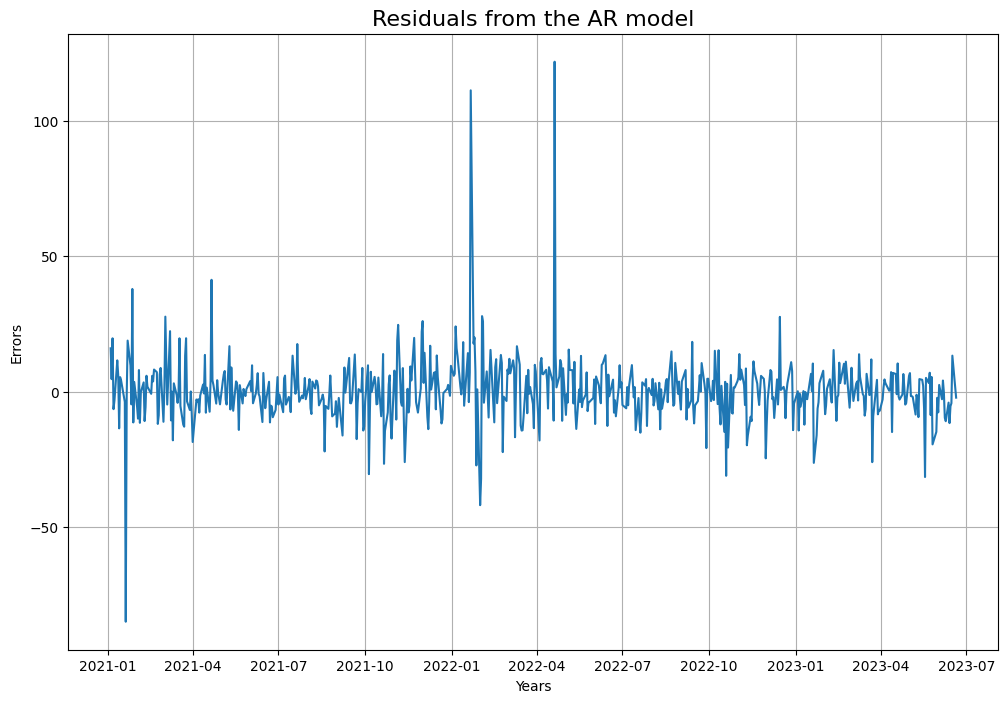

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(df1['error'])
plt.title(f"Residuals from the AR model", fontsize=16)
plt.xlabel("Years")
plt.ylabel("Errors")
plt.grid(True)
plt.show()

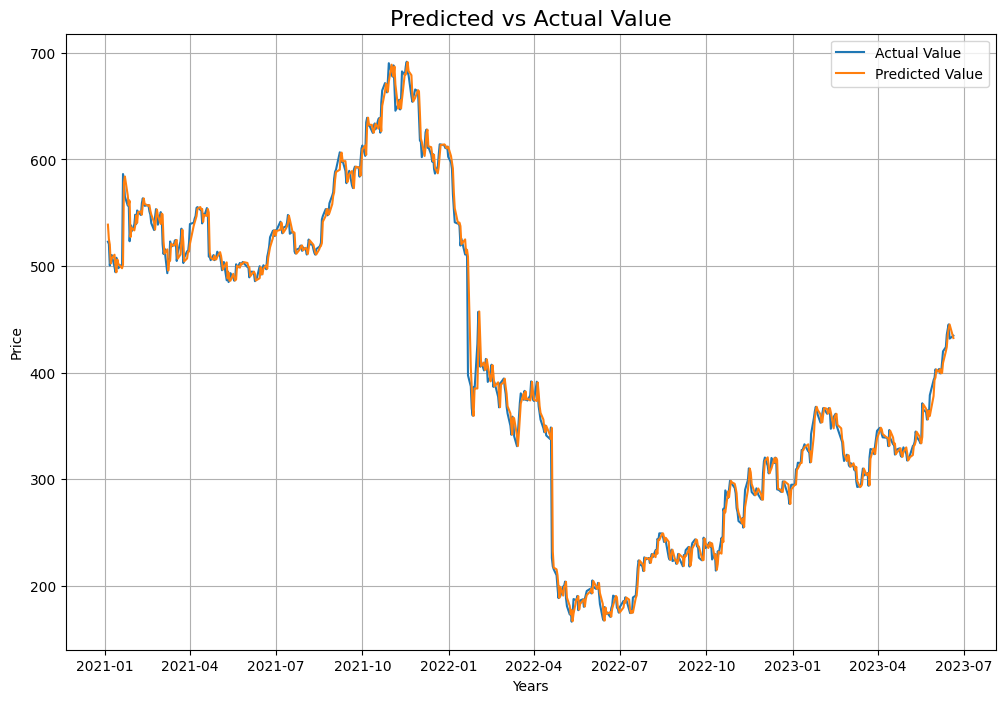

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(df1['Adj Close'], label = 'Actual Value')
plt.plot(df1['prediction'], label = 'Predicted Value')
plt.title(f"Predicted vs Actual Value", fontsize=16)
plt.xlabel("Years")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [25]:
rmse = round(np.sqrt(np.mean(df1['error']**2)), 2)
print("Root mean squared error on out-sample data: ", rmse)

Root mean squared error on out-sample data:  12.15


In [27]:
# Generate the signal
df1['signal'] = np.where(df1['prediction'] > df1['Adj Close'], 1, -1)
df1['strategy_returns'] = df1['Adj Close'].pct_change() * df1['signal'].shift(1) 
df1.dropna(inplace=True)

In [ ]:
pf.create_simple_tear_sheet(df1['strategy_returns'])

Start date,2021-01-05
End date,2023-06-20
Total months,29
,Backtest
Annual return,6.0%
Cumulative returns,15.4%
Annual volatility,51.8%
Sharpe ratio,0.37
Calmar ratio,0.13
Stability,0.27
Max drawdown,-47.7%
